# Edge Detection in Images

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Edges in images are discontinuities in intensity. They usually represent the boundaries of objects or lighting present in the image. It is one of the first steps in object detection models. Here, we will attempt to build an algorithm that can detect edges using the principles of numerical differentiation.

## RGB to Grayscale Conversion
Using the formula 

$$
G = 0.3r + 0.59g + 0.11b
$$

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.3, 0.59, 0.11])

## Image Smoothing
Linear smoothing which averages the pixel count with all 9 of its neighbours.

In [ ]:
def blur(img, file=False):
    if file:
        img = mpimg.imread(img)
        img = rgb2gray(img)
    n = img.shape
    smooth = img.copy()
    # we ignore the edges as they are just 1 pixel
    for x in range(1, n[0]-1):
        for y in range(n[1]-1):
            smooth[x,y] = (img[x,y]+img[x-1,y]+img[x+1,y]+\
                           img[x,y-1]+img[x-1,y-1]+img[x+1,y-1]+\
                           img[x,y+1]+img[x-1,y+1]+img[x+1,y+1])/9
    return smooth

## Masking Function

In [ ]:
def mask(img, k=0.25):
    mk = np.where(img > k*np.max(img), 1, 0)
    return mk
    # fig = plt.figure()
    # im = plt.imshow(mk, cmap='gray')
    # fig.colorbar(im)

## First Derivative approach

The gradient of a 2D scalar matrix will give us the overall change in intensity around every point. If $G$ represents our scalar matrix, the gradient at any point $(i,j)$ can be written as,

$$
\nabla G \approx \biggl \langle \frac{G(x+1,y)-G(x-1,y)}{2} , \frac{G(x,y+1)-G(x,y-1)}{2}\biggl \rangle 
$$

We can also extend this to the second order approximation (which includes 2 neighbouring pixels).

$$
    f'(x) = \frac{8\left[f(x+1)-f(x-1)\right] - \left[f(x+2)-f(x-2)\right]}{12}
$$

In [ ]:
def nablaG(G,x,y,h=1):
    if h == 1:
        delx = (G[x+1,y]-G[x-1,y])/2
        dely = (G[x,y+1]-G[x,y-1])/2
    elif h == 2:
        delx = (8*G[x+1,y]-G[x+2,y]-8*G[x-1,y]+G[x-2,y])/12
        dely = (8*G[x,y+1]-G[x,y+2]-8*G[x,y-1]+G[x,y-2])/12
    else: 
        return (0, 0)
    return (delx, dely)

def gradient(img, h=1, file=False):
    if file:
        img = mpimg.imread(img)
        img = rgb2gray(img)
    n = img.shape
    grad = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    for x in range(h, img.shape[0]-h):
        for y in range(h, img.shape[1]-h):
            g = nablaG(img, x, y, h=h)
            grad[x, y] = np.sqrt(g[0]**2+g[1]**2)
    return grad

### Examples

In [ ]:
def show_edges(file, k=0.25, size=(12, 8)):
    img_rgb = mpimg.imread(f'data/{file}')
    img = rgb2gray(img_rgb)

    plt.figure(figsize=size)    

    plt.subplot(231),plt.imshow(img_rgb)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    grad1 = gradient(img)
    plt.subplot(232),plt.imshow(mask(grad1, k=k), cmap = 'gray')
    plt.title('Gradient $(k=$'+f'{k})'), plt.xticks([]), plt.yticks([])
    
    grad2 = gradient(blur(img))
    plt.subplot(233),plt.imshow(mask(grad2, k=k),cmap = 'gray')
    plt.title('Gradient (after smoothing, $k=$'+f'{k})'), plt.xticks([]), plt.yticks([])

    grad3 = gradient(img, h=3)
    plt.subplot(234),plt.imshow(mask(grad3, k=k), cmap = 'gray')
    plt.title('Gradient $(k=$'+f'{k}, h=2)'), plt.xticks([]), plt.yticks([])
    
    grad4 = gradient(blur(img), h=2)
    plt.subplot(235),plt.imshow(mask(grad4, k=k),cmap = 'gray')
    plt.title('Gradient (after smoothing, $k=$'+f'{k}, h=2)'), plt.xticks([]), plt.yticks([])
    
    edges = cv.Canny(cv.imread(f'data/{file}', cv.IMREAD_GRAYSCALE), 100, 200)
    plt.subplot(236),plt.imshow(edges, cmap = 'gray')
    plt.title('OpenCV Edge Detection'), plt.xticks([]), plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(f'plots/1/{file}', dpi=200)
    plt.show()

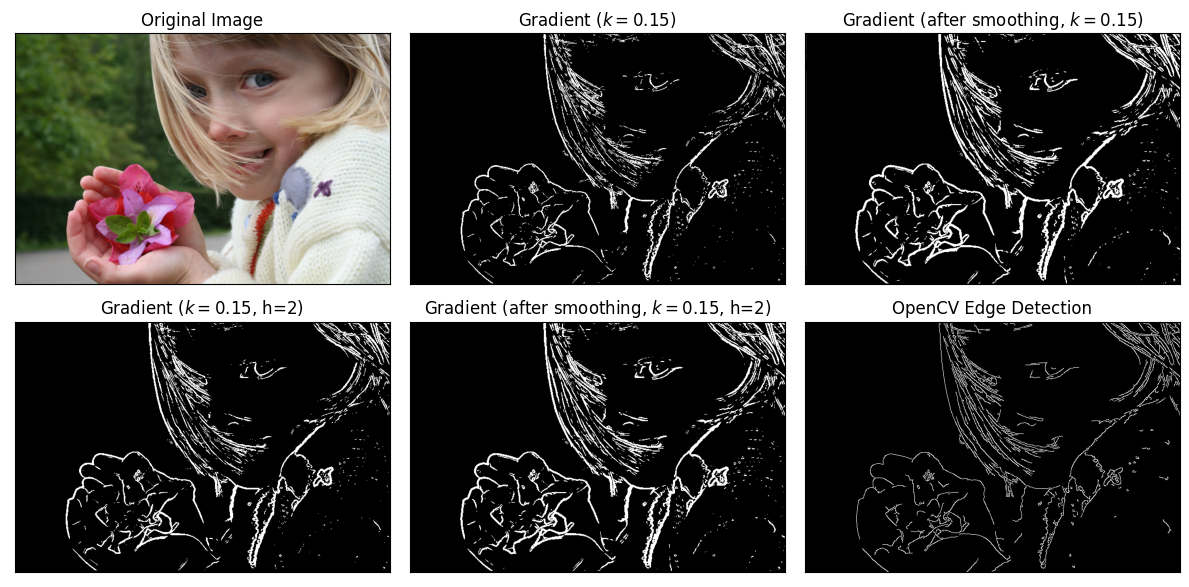

In [ ]:
show_edges('kid.png', k=0.15, size=(12,6))

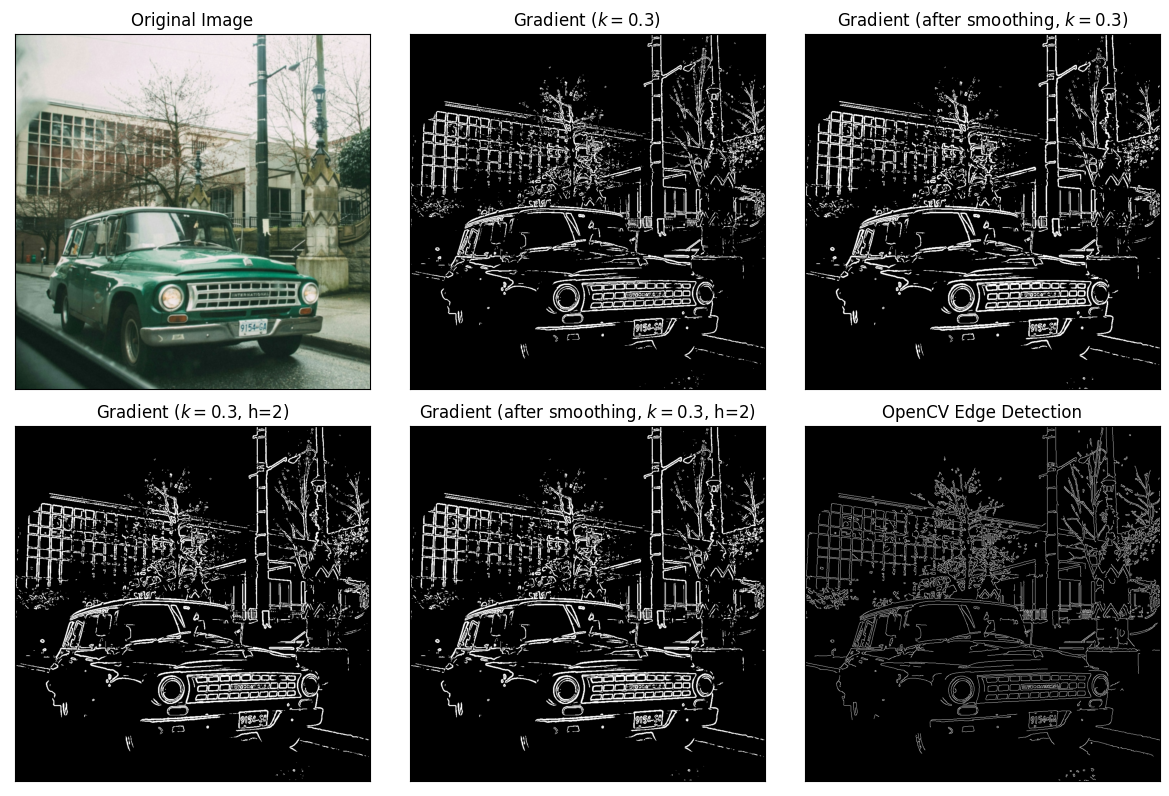

In [ ]:
show_edges('cara.png', k=0.3, size=(12,8))

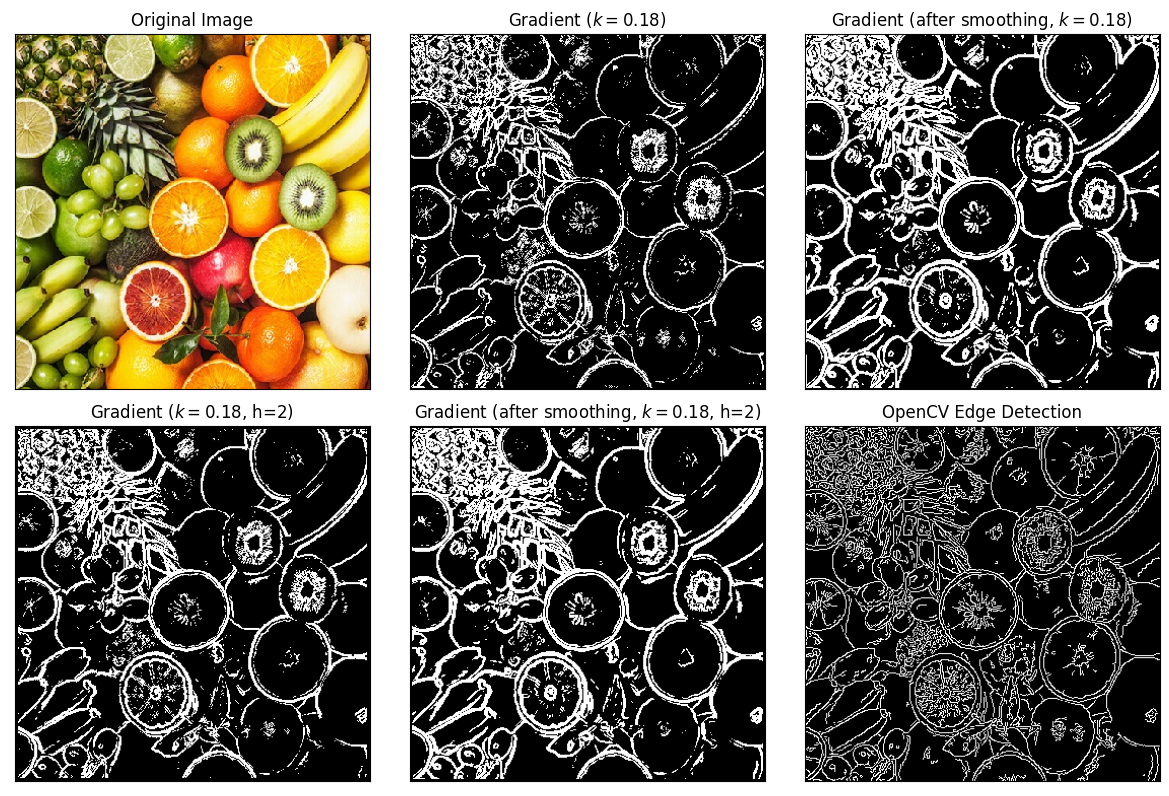

In [ ]:
show_edges('fruits.jpg', k=0.18, size=(12,8))

## Second Derivative approach

As we have seen in the previous section, the local maxima/minima in gradient values represent edge points. This means that at edge points, there will be a peak in the first derivative, and equivalently, there will be a zero crossing in the second derivative. Thus, edge points may be detected by finding the zero crossings of the second derivative of the image intensity.

The simplest way to find the second derivate of a scalar matrix is to find its Laplacian. Using the Taylor series expansion mentioned earlier, we can calculate the second derivate of a function as 

$$
    f''(x) = f(x+h)+f(x-h)-2f(x)
$$

Thus, the two-dimensional Laplacian will be,

$$
    \nabla^2 G(x,y) = \frac{1}{h^2}\left(G(x,y+1)+G(x,y-1)+G(x-1,y)+G(x-1,y)-4G(x,y)\right)
$$

In [112]:
def laplacian(img, h=1, file=True):
    if file:
        img = mpimg.imread(img)
        img = rgb2gray(img)
    lap = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    for x in range(h, img.shape[0]-h):
        for y in range(h, img.shape[1]-h):
            try:
                np.seterr(over='ignore')
                lap[x, y] = (img[x,y+1]+img[x,y-1]+img[x+1,y]+img[x-1,y]-4*img[x,y])/h**2
            except RuntimeWarning as e:
                # If a RuntimeWarning occurs, print the warning message
                print(f"RuntimeWarning: {e}")
                print(img[x,y+1],img[x,y-1],img[x+1,y],img[x-1,y],4*img[x,y])
    return lap

def zero_crossings(img):
    mk = np.ones((img.shape[0],img.shape[1]))
    for x in range(1, img.shape[0]-1):
        for y in range(1, img.shape[1]-1):
            pix = img[x,y]
            if pix*img[x-1,y] < 0 or pix*img[x+1,y] < 0 or pix*img[x,y+1] < 0 or pix*img[x,y-1] < 0:
                mk[x,y] = 0
    return mk

### Examples

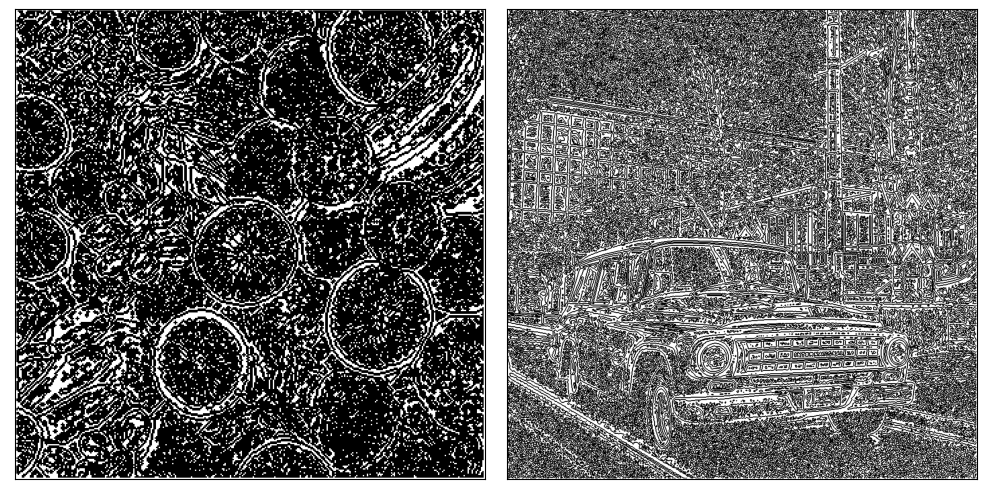

In [ ]:
plt.figure(figsize=(10,5))    

plt.subplot(121)
lap = laplacian(blur('data/fruits.jpg', file=True), file=False)
im = plt.imshow(zero_crossings(lap), cmap='gray')
plt.xticks([]), plt.yticks([]) 

plt.subplot(122)
lap = laplacian(blur('data/cara.png', file=True), file=False)
im = plt.imshow(zero_crossings(lap), cmap='gray')
plt.xticks([]), plt.yticks([])

plt.tight_layout() 
plt.savefig('plots/1/edge2.jpg', dpi=200)